## Neural networks for segmentation

In [1]:
! wget https://www.dropbox.com/s/jy34yowcf85ydba/data.zip?dl=0 -O data.zip
! unzip -q data.zip

--2018-04-02 20:20:17--  https://www.dropbox.com/s/jy34yowcf85ydba/data.zip?dl=0
Resolving www.dropbox.com (www.dropbox.com)... 2620:100:6022:1::a27d:4201, 162.125.66.1
Connecting to www.dropbox.com (www.dropbox.com)|2620:100:6022:1::a27d:4201|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://dl.dropboxusercontent.com/content_link/Y4I9PiAu3rY7HdqgtjVaJuOjMWY2r7cRAUfhSIZ9RQ2wV2fDFb1rjH9Go0Knqmhn/file [following]
--2018-04-02 20:20:17--  https://dl.dropboxusercontent.com/content_link/Y4I9PiAu3rY7HdqgtjVaJuOjMWY2r7cRAUfhSIZ9RQ2wV2fDFb1rjH9Go0Knqmhn/file
Resolving dl.dropboxusercontent.com (dl.dropboxusercontent.com)... 2620:100:6022:6::a27d:4206, 162.125.66.6
Connecting to dl.dropboxusercontent.com (dl.dropboxusercontent.com)|2620:100:6022:6::a27d:4206|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 17887724 (17M) [application/zip]
Saving to: ‘data.zip’

data.zip            100%[===================>]  17,06M  5,18MB/s    in 3,

Your next task is to train neural network to segment cells edges.

Here is an example of input data with corresponding ground truth:

In [1]:
import scipy as sp
import scipy.misc
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline

/home/ilivans/.virtualenvs/dl/lib/python3.5/site-packages/ipykernel_launcher.py:4: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.
  after removing the cwd from sys.path.
/home/ilivans/.virtualenvs/dl/lib/python3.5/site-packages/ipykernel_launcher.py:7: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.
  import sys


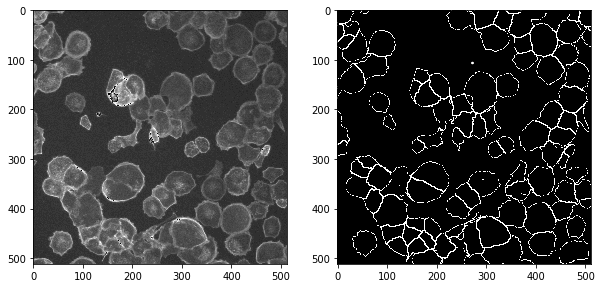

In [2]:
# Human HT29 colon-cancer cells
plt.figure(figsize=(10,8))
plt.subplot(1,2,1)
im = sp.misc.imread('BBBC018_v1_images-fixed/train/00735-actin.DIB.bmp')
plt.imshow(im[:,:,1], 'gray')
plt.subplot(1,2,2)
mask = sp.misc.imread('BBBC018_v1_outlines/train/00735-cells.png')
plt.imshow(mask, 'gray')

This time you aren't provided with any code snippets, just input data and target metric - intersection-over-union (IoU) (see implementation below).

You should train neural network to predict mask of edge pixels (pixels in gt images with value greater than 0).

Use everything you've learnt by now: 
* any architectures for semantic segmentation (encoder-decoder like or based on dilated convolutions)
* data augmentation (you will need that since train set consists of just 41 images)
* fine-tuning

You're not allowed to do only one thing: to train you network on test set.

Your final solution will consist of an ipython notebook with code (for final network training + any experiments with data) and an archive with png images with network predictions for test images (one-channel images, 0 - for non-edge pixels, any non-zero value for edge pixels).

Forestalling questions about baseline... well, let's say that a good network should be able to segment images with iou >= 0.29. This is not a strict criterion of full points solution, but try to obtain better numbers.

Practical notes:
* There is a hard data class imbalance in dataset, so the network output will be biased toward "zero" class. You can either tune the minimal probability threshold for "edge" class, or add class weights to increase the cost of edge pixels in optimized loss.
* Dataset is small so actively use data augmentation: rotations, flip, random contrast and brightness
* Better spend time on experiments with neural network than on postprocessing tricks (i.e test set augmentation).
* Keep in mind that network architecture defines receptive field of pixel. If the size of network input is smaller than receptive field of output pixel, than probably you can throw some layers without loss of quality. It is ok to modify "of-the-shelf" architectures. 

Good luck!

In [3]:
def calc_iou(prediction, ground_truth):
    n_images = len(prediction)
    intersection, union = 0, 0
    for i in range(n_images):
        intersection += np.logical_and(prediction[i] > 0, ground_truth[i] > 0).astype(np.float32).sum() 
        union += np.logical_or(prediction[i] > 0, ground_truth[i] > 0).astype(np.float32).sum()
    return float(intersection) / union

In [4]:
import torch
import torch.nn.functional as F
from torch import nn

def initialize_weights(*models):
    for model in models:
        for module in model.modules():
            if isinstance(module, nn.Conv2d) or isinstance(module, nn.Linear):
                nn.init.kaiming_normal(module.weight)
                if module.bias is not None:
                    module.bias.data.zero_()
            elif isinstance(module, nn.BatchNorm2d):
                module.weight.data.fill_(1)
                module.bias.data.zero_()


class _EncoderBlock(nn.Module):
    def __init__(self, in_channels, out_channels, dropout=False):
        super(_EncoderBlock, self).__init__()
        layers = [
            nn.Conv2d(in_channels, out_channels, kernel_size=3),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, kernel_size=3),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
        ]
        if dropout:
            layers.append(nn.Dropout())
        layers.append(nn.MaxPool2d(kernel_size=2, stride=2))
        self.encode = nn.Sequential(*layers)

    def forward(self, x):
        return self.encode(x)


class _DecoderBlock(nn.Module):
    def __init__(self, in_channels, middle_channels, out_channels):
        super(_DecoderBlock, self).__init__()
        self.decode = nn.Sequential(
            nn.Conv2d(in_channels, middle_channels, kernel_size=3),
            nn.BatchNorm2d(middle_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(middle_channels, middle_channels, kernel_size=3),
            nn.BatchNorm2d(middle_channels),
            nn.ReLU(inplace=True),
            nn.ConvTranspose2d(middle_channels, out_channels, kernel_size=2, stride=2),
        )

    def forward(self, x):
        return self.decode(x)


class UNet(nn.Module):
    def __init__(self, num_classes):
        super(UNet, self).__init__()
        self.enc1 = _EncoderBlock(1, 64)
        self.enc2 = _EncoderBlock(64, 128)
        self.enc3 = _EncoderBlock(128, 256)
        self.enc4 = _EncoderBlock(256, 512, dropout=True)
        self.center = _DecoderBlock(512, 1024, 512)
        self.dec4 = _DecoderBlock(1024, 512, 256)
        self.dec3 = _DecoderBlock(512, 256, 128)
        self.dec2 = _DecoderBlock(256, 128, 64)
        self.dec1 = nn.Sequential(
            nn.Conv2d(128, 64, kernel_size=3),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.Conv2d(64, 64, kernel_size=3),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
        )
        self.final = nn.Conv2d(64, num_classes, kernel_size=1)
        initialize_weights(self)

    def forward(self, x):
        enc1 = self.enc1(x)
        enc2 = self.enc2(enc1)
        enc3 = self.enc3(enc2)
        enc4 = self.enc4(enc3)
        center = self.center(enc4)
        dec4 = self.dec4(torch.cat([center, F.upsample(enc4, center.size()[2:], mode='bilinear')], 1))
        dec3 = self.dec3(torch.cat([dec4, F.upsample(enc3, dec4.size()[2:], mode='bilinear')], 1))
        dec2 = self.dec2(torch.cat([dec3, F.upsample(enc2, dec3.size()[2:], mode='bilinear')], 1))
        dec1 = self.dec1(torch.cat([dec2, F.upsample(enc1, dec2.size()[2:], mode='bilinear')], 1))
        final = self.final(dec1)
        return F.upsample(final, x.size()[2:], mode='bilinear')

In [5]:
from pathlib import Path
from torch.utils.data import Dataset


class MyDataset(Dataset):
    def __init__(self, root_dir, root_dir2=None, transform1=None, transform2=None):
        self.transform1 = transform1
        self.transform2 = transform2
        self.paths = list(sorted(Path(root_dir).iterdir()))
        self.paths_masks = list(sorted(Path(root_dir2).iterdir())) if root_dir2 else None

    def __len__(self):
        return len(self.paths)

    def __getitem__(self, idx):
        im = io.imread(self.paths[idx])[:,:,1:2]
        mask = io.imread(self.paths_masks[idx])[:,:, None] if (self.paths_masks is not None) else None
        seed = np.random.randint(2147483647)
        if self.transform1:
            np.random.seed(seed)
            im = self.transform1(im)            
            if mask is not None:
                np.random.seed(seed)
                mask = self.transform2(mask)
        return im, mask

In [6]:
from scipy.ndimage import io

means = np.array([io.imread(i).mean(axis=(0, 1))[1:2] for i in Path('BBBC018_v1_images-fixed/train').iterdir()]).mean(axis=0)
stds = np.array([io.imread(i).std(axis=(0, 1))[1:2] for i in Path('BBBC018_v1_images-fixed/train').iterdir()]).mean(axis=0)

/home/ilivans/.virtualenvs/dl/lib/python3.5/site-packages/ipykernel_launcher.py:3: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0.
Use ``matplotlib.pyplot.imread`` instead.
  This is separate from the ipykernel package so we can avoid doing imports until
/home/ilivans/.virtualenvs/dl/lib/python3.5/site-packages/ipykernel_launcher.py:4: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0.
Use ``matplotlib.pyplot.imread`` instead.
  after removing the cwd from sys.path.


/home/ilivans/.virtualenvs/dl/lib/python3.5/site-packages/ipykernel_launcher.py:16: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0.
Use ``matplotlib.pyplot.imread`` instead.
  app.launch_new_instance()
/home/ilivans/.virtualenvs/dl/lib/python3.5/site-packages/ipykernel_launcher.py:17: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0.
Use ``matplotlib.pyplot.imread`` instead.


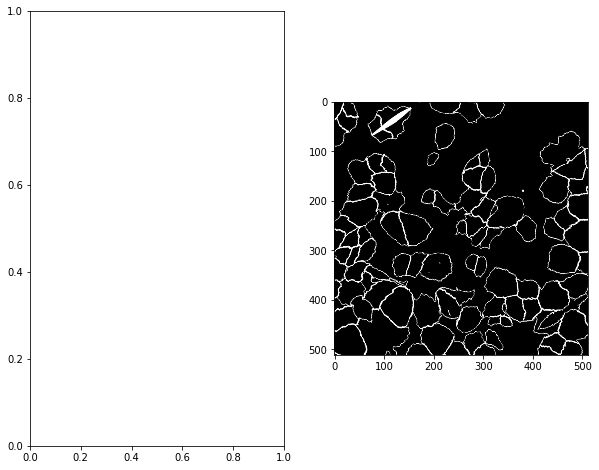

In [7]:
from torchvision import transforms

from imageUtils import ElasticTransform, RandomRotate

transformed_dataset = MyDataset(root_dir='BBBC018_v1_images-fixed/train',
                               root_dir2='BBBC018_v1_outlines/train',
                               transform1=transforms.Compose([
                                   ElasticTransform(alpha=1000, sigma=30),
                                   RandomRotate(),
                                   transforms.ToTensor(),
                                   transforms.Normalize(means, stds)
                                ]),
                               transform2=transforms.Compose([
                                   ElasticTransform(alpha=1000, sigma=30),
                                   RandomRotate(),
                                   transforms.ToTensor()
                                ]))

for i in range(len(transformed_dataset)):
    im, mask = transformed_dataset[i]
    plt.figure(figsize=(10,8))
    plt.subplot(1,2,1)
#     plt.imshow(im.numpy()[0], 'gray')
    plt.subplot(1,2,2)
    plt.imshow(mask.numpy()[0], 'gray')
    plt.show()
    break

In [8]:
import gc
import time

from tqdm import tqdm_notebook as tqdm
from torch.autograd import Variable

num_epochs = 1 # total amount of full passes over training data
batch_size = 1  # number of samples processed in one SGD iteration

dataset_loader = torch.utils.data.DataLoader(transformed_dataset,
                                             batch_size=batch_size, shuffle=True,
                                             num_workers=1)

val_loader = torch.utils.data.DataLoader(MyDataset(root_dir='BBBC018_v1_images-fixed/val',
                                                   root_dir2='BBBC018_v1_outlines/val',
                                                   transform1=transforms.ToTensor(),
                                                   transform2=transforms.ToTensor()),
                                             batch_size=1, shuffle=False,
                                             num_workers=1)
y_val = np.asarray([i[1].numpy() for i in val_loader])

model = UNet(1)
opt = torch.optim.Adam(model.parameters())

train_loss = []
y_pred = []
val_loss = []
val_accuracy = []

def compute_loss(X_batch, y_batch):
    X_var = Variable(X_batch)
    y_binary = y_batch > 0
    y_binary_arr = y_binary.numpy()
    y_var = Variable(y_binary.float())
    logits = model(X_var)
#     print(logits.shape, y_batch.shape)
    weight = y_binary_arr + y_binary_arr.sum() / y_binary_arr.size
    weight = Variable(torch.FloatTensor(weight))
    return F.binary_cross_entropy_with_logits(logits, y_var, weight).mean()

for epoch in range(num_epochs):
    # In each epoch, we do a full pass over the training data:
    start_time = time.time()
    model.train(True) # enable dropout / batch_norm training behavior
    for X_batch, y_batch in tqdm(dataset_loader, desc="train"):
        # train on batch
        loss = compute_loss(X_batch, y_batch)
        loss.backward()
        opt.step()
        opt.zero_grad()
        train_loss.append(loss.data.numpy()[0])
        gc.collect()
        
    # And a full pass over the validation data:
    model.train(False) # disable dropout / use averages for batch_norm
    for X_batch, y_batch in tqdm(val_loader, desc="val"):
        logits = model(Variable(torch.FloatTensor(X_batch)))
        y_pred.append(logits.data.numpy())
        val_loss.append(loss.data.numpy()[0])
        gc.collect()
    val_accuracy.append(calc_iou(np.array(y_pred), y_val))
    
    # Then we print the results for this epoch:
    print("Epoch {} of {} took {:.3f}s".format(
        epoch + 1, num_epochs, time.time() - start_time))
    print("  training loss (in-iteration): \t{:.6f}".format(
        np.mean(train_loss[-len(dataset_loader) // batch_size :])))
    print("  val loss (in-iteration): \t{:.6f}".format(
        np.mean(val_loss[-len(val_loader) // batch_size :])))
    print("  validation accuracy: \t\t\t{:.2f} %".format(
        val_accuracy[-1]))

/home/ilivans/.virtualenvs/dl/lib/python3.5/site-packages/ipykernel_launcher.py:16: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0.
Use ``matplotlib.pyplot.imread`` instead.
  app.launch_new_instance()
/home/ilivans/.virtualenvs/dl/lib/python3.5/site-packages/ipykernel_launcher.py:17: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0.
Use ``matplotlib.pyplot.imread`` instead.


/home/ilivans/.virtualenvs/dl/lib/python3.5/site-packages/ipykernel_launcher.py:16: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0.
Use ``matplotlib.pyplot.imread`` instead.
  app.launch_new_instance()
/home/ilivans/.virtualenvs/dl/lib/python3.5/site-packages/ipykernel_launcher.py:17: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0.
Use ``matplotlib.pyplot.imread`` instead.


/home/ilivans/.virtualenvs/dl/lib/python3.5/site-packages/ipykernel_launcher.py:16: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0.
Use ``matplotlib.pyplot.imread`` instead.
  app.launch_new_instance()
/home/ilivans/.virtualenvs/dl/lib/python3.5/site-packages/ipykernel_launcher.py:17: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0.
Use ``matplotlib.pyplot.imread`` instead.



Epoch 1 of 1 took 568.320s
  training loss (in-iteration): 	0.123365
  val loss (in-iteration): 	0.185702
  validation accuracy: 			0.05 %


In [11]:
def logits_to_binary(logits, thr=0.001):
    exps = np.exp(y_pred[0])
    sm = exps / exps.sum()
    return (sm > thr).astype(np.float32)

(array([1.50000e+01, 4.82000e+02, 1.59540e+04, 1.21558e+05, 9.45820e+04,
        2.48390e+04, 3.80100e+03, 8.24000e+02, 8.60000e+01, 3.00000e+00]),
 array([ 3.7428019 ,  6.22477629,  8.70675068, 11.18872507, 13.67069945,
        16.15267384, 18.63464823, 21.11662261, 23.598597  , 26.08057139,
        28.56254578]),
 <a list of 10 Patch objects>)

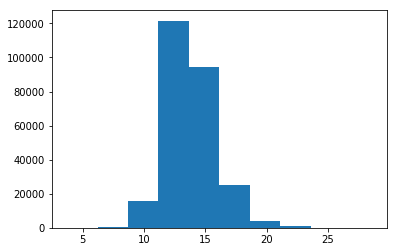

In [23]:
plt.hist(y_pred[2].flatten())

In [35]:
calc_iou(np.array([logits_to_binary(i, 1e-7) for i in y_pred]), y_val)

0.05369412103486495

In [90]:
import gc
# del model
gc.collect()

0